<a href="https://colab.research.google.com/github/PuruB1197/personalproject_datascience/blob/main/Predicting%20Rings%20of%20Abalone%20using%20physical%20measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hey there, this is my first project and in this I am just building a regression model to predict the rings of Abalone from physical measurement.
This is a practice exercise, I got this inspiration from a youtube video
Thanks 

In [272]:
""" We will first import libraries """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as m
from pandas_profiling import ProfileReport

from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import BaggingRegressor as Br

import lightgbm as lgb


from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV




%matplotlib inline

# 1. Reading data and basic view

In [216]:
ab_df=pd.read_csv(r"abalone.data",header=None,index_col=False)
ab_df.columns=['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
ab_df.head(100)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
...,...,...,...,...,...,...,...,...,...
95,M,0.665,0.535,0.195,1.6060,0.5755,0.3880,0.480,14
96,M,0.535,0.435,0.150,0.7250,0.2690,0.1385,0.250,9
97,M,0.470,0.375,0.130,0.5230,0.2140,0.1320,0.145,8
98,M,0.470,0.370,0.130,0.5225,0.2010,0.1330,0.165,7


# 2.EDA

In [217]:
## shape and columns name
print("shaape of the dataframe: ",ab_df.shape)
print("the columns name: ",ab_df.columns.to_list())

shaape of the dataframe:  (4177, 9)
the columns name:  ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']


In [218]:
## getting the attribute type
attribute_type=pd.DataFrame(ab_df.dtypes).reset_index().rename(columns={"index":"attribute",0:"datatype"})
attribute_type

,attribute,datatype
0,sex,object
1,length,float64
2,diameter,float64
3,height,float64
4,whole_weight,float64
5,shucked_weight,float64
6,viscera_weight,float64
7,shell_weight,float64
8,rings,int64


In [219]:
list_n=[] ### listing down which columns are numericals
list_o=[] ### listing down which columns are objects
for i in range(attribute_type.shape[0]):
  if attribute_type.loc[i,'datatype'] in (['int64','float64']):
    list_n.append(attribute_type.loc[i,'attribute'])
  else:
    list_o.append(attribute_type.loc[i,'attribute'])
list_n,list_o

(['length',
  'diameter',
  'height',
  'whole_weight',
  'shucked_weight',
  'viscera_weight',
  'shell_weight',
  'rings'],
 ['sex'])

In [220]:
### counting of datatypes, though not needed :p (just for fun)
pd.DataFrame(ab_df.dtypes).reset_index().groupby([0])['index'].agg({'count'}).reset_index().rename(columns={0:"datatype","count":"count of type"})

### just for some extra fun in lambda functions ::P (come on don't judge me )
# pd.DataFrame(ab_df.dtypes).reset_index().groupby([0])['index'].agg({'count'}).reset_index().rename(columns={0:"datatype","count":"count of type"})['datatype'].apply(lambda x:'numeric' if x in(['int64','float64']) else ('catgorical' if x=='object'else 'k'))


,datatype,count of type
0,int64,1
1,float64,7
2,object,1


In [221]:
## % of null values in the attribute
for i in list(ab_df.columns):
  print("The percentage of null values in attribute " + str(i.upper()) +" "+ str(ab_df[i].isna().sum()/len(ab_df[i]))+str("%"))

The percentage of null values in attribute SEX 0.0%
The percentage of null values in attribute LENGTH 0.0%
The percentage of null values in attribute DIAMETER 0.0%
The percentage of null values in attribute HEIGHT 0.0%
The percentage of null values in attribute WHOLE_WEIGHT 0.0%
The percentage of null values in attribute SHUCKED_WEIGHT 0.0%
The percentage of null values in attribute VISCERA_WEIGHT 0.0%
The percentage of null values in attribute SHELL_WEIGHT 0.0%
The percentage of null values in attribute RINGS 0.0%


In [222]:
### desrcribe every feature
ab_df.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [223]:
### unique count of categorical fearure
for i in (list_o):
  print(ab_df[i].unique())

['M' 'F' 'I']


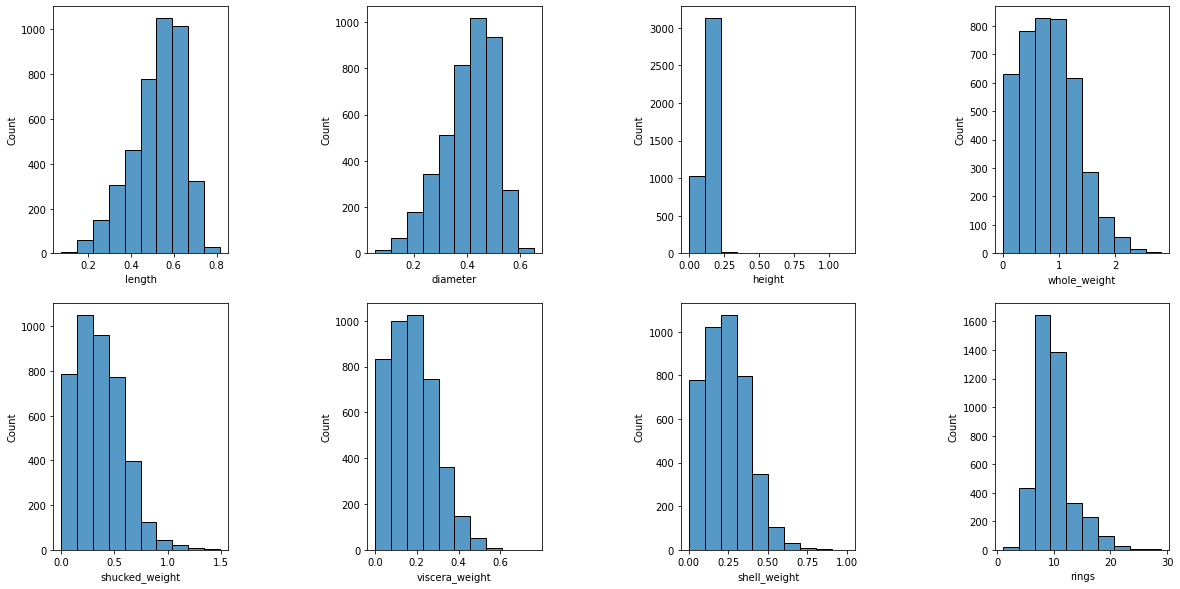

In [224]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig,axes
ab_df_sub=ab_df[[i for i in (list_n)]]
for i, j in enumerate(ab_df_sub.columns):
  sns.histplot(ab_df_sub[j],ax=axes[i // 4, i % 4], bins=10)

plt.subplots_adjust(wspace = 0.8)

In [225]:
### checking correlation by first calculating and then plotting heat plot
ab_df.corr() ### it seems many features have high correlations uffff, but this will not make me statisfied (Michael scott on my mind:p), will see what else we can do in later steps

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
whole_weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
shucked_weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
viscera_weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
shell_weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


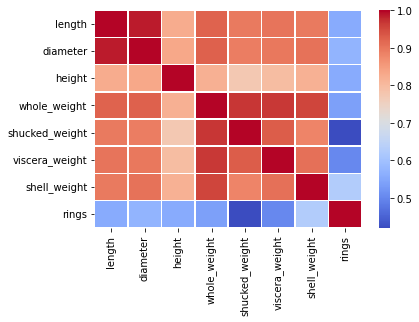

In [226]:
ab_df_sub=ab_df[[i for i in (list_n)]]
# ab_df_sub
sns.heatmap(ab_df_sub.corr(),linewidth = 0.5 , cmap = 'coolwarm')

In [227]:
### checking VIF scores too for all the independent variable, it means we have to treat variables to get the best model
x=pd.DataFrame()
feat=["height","whole_weight","shell_weight","viscera_weight"]
x['Independent_fe']=ab_df_sub.iloc[:,:-1].columns
x['VIF_score']=[variance_inflation_factor(ab_df_sub.iloc[:,:-1].values,i) for i  in range (ab_df_sub.shape[1]-1)]

x

,Independent_fe,VIF_score
0,length,695.083714
1,diameter,748.879248
2,height,42.117537
3,whole_weight,421.579746
4,shucked_weight,101.575906
5,viscera_weight,63.348265
6,shell_weight,81.772105


In [228]:
### in this first I tried to look by removing highy correlated variables but as still there is not much improvement in VIF score so I thought to combine some 
## variable and result is, one can also try to remove other features and see if the high VIF featrurs are getting lesser VIF now


feat=["height","shell_weight","viscera_weight"]
feat1=["height","com"]

c=ab_df[["height","shell_weight","viscera_weight"]]
c['com']=c["shell_weight"]+ c["viscera_weight"]
del c['shell_weight']
del c['viscera_weight']
print(c.columns)
y=pd.DataFrame()
y['ind']=c[[i for i in feat1]].columns
y['VIF_score']=[variance_inflation_factor(c.values,i) for i  in range (2)]
y

Index(['height', 'com'], dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,ind,VIF_score
0,height,9.870807
1,com,9.870807


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

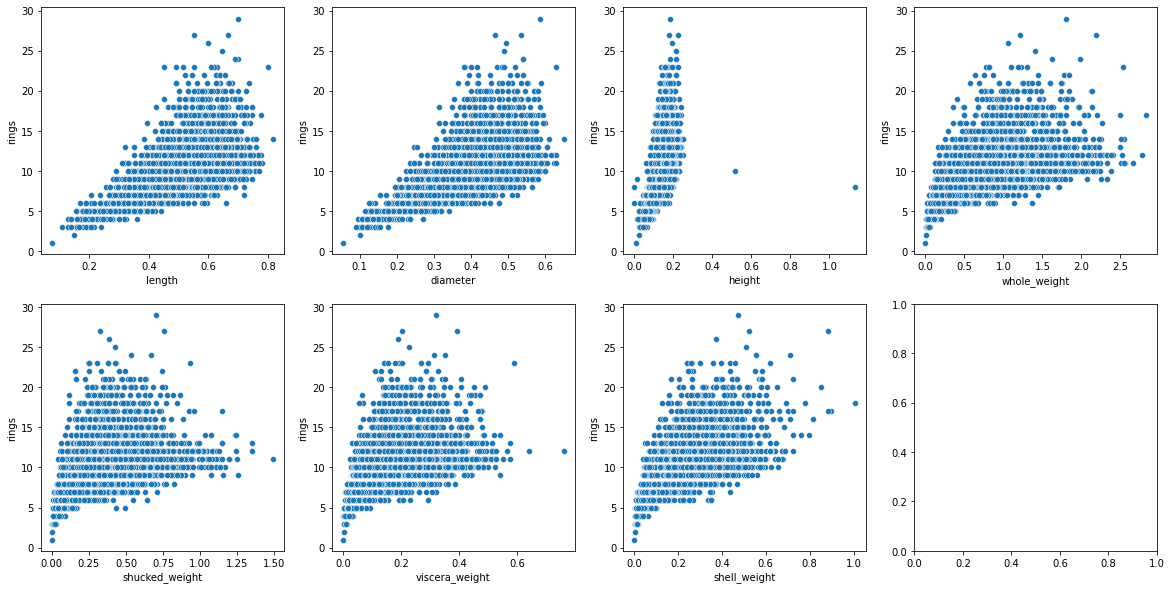

In [229]:
fig, axes=plt.subplots(2,4, figsize=(20,10))

for i, j in enumerate(ab_df_sub.iloc[:,:-1]):
  sns.scatterplot(ab_df_sub.iloc[:,:-1][j],ab_df_sub['rings'],ax=axes[i//4,i%4])

# 3. feature Engineering

In [230]:
### since one categorical variable and also it has less number of unique values ( only male and female)
treated_data=pd.get_dummies(ab_df)
treated_data.head()
treated_data['com']=treated_data['shell_weight']+treated_data['viscera_weight']
# treated_data=treated_data[['height','com','sex_F','sex_I','sex_M','rings']]
treated_data.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M,com
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1,0.2510
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1,0.1185
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0,0.3515
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1,0.2690
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0,0.0945


# 4. Model Preparation and model 

In [231]:
training_set=treated_data.iloc[:4099,:]
validation_set=treated_data.iloc[4099:,:]
print(training_set.shape)
print(validation_set.shape)

(4099, 12)
(78, 12)


In [232]:
X=training_set[['height','length']]
Y=training_set['rings'].values.reshape(-1,1)

X_val=validation_set[['height','length']]
Y_val=validation_set['rings'].values.reshape(-1,1)

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2, random_state=100)

# Model-1: Multiple regression model

In [233]:
reg=LR()
test_pred=reg.fit(X_train,y_train).predict(X_test)
### Test RMSE
test_rmse= mse(y_test,test_pred,squared=False)
print("test rmse: ", test_rmse)
### Val RMSE
val_pred=reg.predict(X_val)
val_rmse= mse(Y_val,val_pred,squared=False)
print("val rmse: ",val_rmse)

test rmse:  2.616785273213457
val rmse:  1.5413411488870246


# Model-2: Multiple Regressionn with Regularization (Ridge/Lasso)

In [239]:
def find_best_param(X_t,Y_t,str1):
  parameters ={'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
  if str1=='Ridge':
    print('Ri')
    rd=Ridge()
    rid_re=GridSearchCV(rd, parameters, scoring='neg_root_mean_squared_error',cv=5)
    rid_re.fit(X_t,Y_t)
    print(-rid_re.best_score_)
    return rid_re.best_params_
  if str1=='Lasso':
    print('la')
    ld=Lasso()
    ld_re=GridSearchCV(ld, parameters, scoring='neg_root_mean_squared_error',cv=5)
    ld_re.fit(X_t,Y_t)
    print(-ld_re.best_score_)
    return ld_re.best_params_


In [260]:
## ridge
best_param_te=find_best_param(X_train,y_train,'Ridge')
ridge_pre=Ridge(best_param_te['alpha']).fit(X_train,y_train).predict(X_test)
### test RMSE
print("test RMSE: ", mse(y_test,ridge_pre,squared=False))

## val
ridge_val=Ridge(best_param_te['alpha']).fit(X_train,y_train).predict(X_val)
### test RMSE
print("Val RMSE: ", mse(Y_val,ridge_val,squared=False))


Ri
2.6543081107405757
test RMSE:  2.63524190226315
Val RMSE:  1.5401904668756121


In [261]:
## lasso
best_param_te=find_best_param(X_train,y_train,'Lasso')
ridge_pre=Lasso(best_param_te['alpha']).fit(X_train,y_train).predict(X_test)
### test RMSE
print("test RMSE: ", mse(y_test,ridge_pre,squared=False))

## val
ridge_val=Lasso(best_param_te['alpha']).fit(X_train,y_train).predict(X_val)
### test RMSE
print("Val RMSE: ", mse(Y_val,ridge_val,squared=False))

la
2.665150823467157
test RMSE:  2.6569255937590914
Val RMSE:  1.534558647981332


# Model-3: Decision Tree

In [269]:
X=training_set.drop(['rings' ,'diameter', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight'],axis=1)
y=training_set['rings'].values.reshape(-1,1)

X_val=validation_set.drop(['rings' ,'diameter', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight'],axis=1)
y_val=validation_set['rings'].values.reshape(-1,1)

X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=100)

# Model-4: Random Forest Regressor

In [274]:
RandomizedSearchCV,
rf_reg=rfr()
parameters={ "n_estimators":[int(x) for x in range(100,1000,10)]}

rf_reg_1=RandomizedSearchCV(rf_reg,parameters, scoring='neg_mean_squared_error',cv=5)
rf_reg_1.fit(X_train,y_train.ravel())
print(rf_reg_1.best_params_)

{'n_estimators': 460}


In [282]:
## on test and train
rf_reg=rfr(n_estimators=460)
rf_reg_pred=rf_reg.fit(X_train,y_train.ravel()).predict(X_test)

print("test rmse: ",mse(y_test,rf_reg_pred,squared=False))

### on vali
rf_reg_val=rf_reg.predict(X_val)
print("Val rmse: ",mse(Y_val,rf_reg_val,squared=False))

test rmse:  2.4646710110441674
Val rmse:  2.0719898565386727


# Model-5: Bagging

In [286]:
bg=Br()
parameters={
    "n_estimators":[int(x) for x in np.linspace(100,1000,10)],
    "max_samples":[float(x) for x in np.arange(0.1, 1.1, 0.1)]
}

br_1=RandomizedSearchCV(bg,parameters,scoring='neg_mean_squared_error',cv=5)
br_1.fit(X_train,y_train.ravel())
print(br_1.best_params_)

{'n_estimators': 900, 'max_samples': 0.1}


In [291]:
## test and Val RMSE
bg_test_pred=Br(n_estimators=900,max_samples=0.1).fit(X_train,y_train.ravel()).predict(X_test)
print("test RMSE: ",mse(y_test,bg_test_pred,squared=False))
print("Val RMSE: ", mse(Y_val,Br(n_estimators=900,max_samples=0.1).fit(X_train,y_train.ravel()).predict(X_val),squared=False))

test RMSE:  2.332331216818981
Val RMSE:  1.7009564671651827


# Model-6: LightGBM

In [297]:
parameter={
    'learning_rate':'0.2'

}
dataset_lgb=lgb.Dataset(X_train.values,label=y_train.ravel())

In [298]:
reg=lgb.train(parameter,dataset_lgb,100)

In [301]:
## test and val rmse
reg_predict=reg.predict(X_test)
print("test rmse: ",mse(y_test,reg_predict,squared=False))
print("Val rmse: ",mse(Y_val,reg.predict(X_val),squared=False))

test rmse:  2.4249945875567778
Val rmse:  1.968605492275813


# Summarizing

In [305]:
rmse_compilation = {
    'model': ['linear regression', 'linear regression + ridge', 'linear regression + lasso', 'random forest', 'bagging', 'LightGBM'],
    'RMSE' : [1.54,1.540190,1.5345,2.07198, 1.70095, 1.96860]
}
pd.DataFrame(data=rmse_compilation).sort_values(by='RMSE')

,model,RMSE
2,linear regression + lasso,1.53450
0,linear regression,1.54000
1,linear regression + ridge,1.54019
4,bagging,1.70095
5,LightGBM,1.96860
3,random forest,2.07198
